<a href="https://colab.research.google.com/github/Imsachin010/UDR-Fused-CNN-Models/blob/main/Resnet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os

In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=3

In [ ]:
# Define the path to the dataset
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/DATABASES/9383",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 564 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['0', '1']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1]


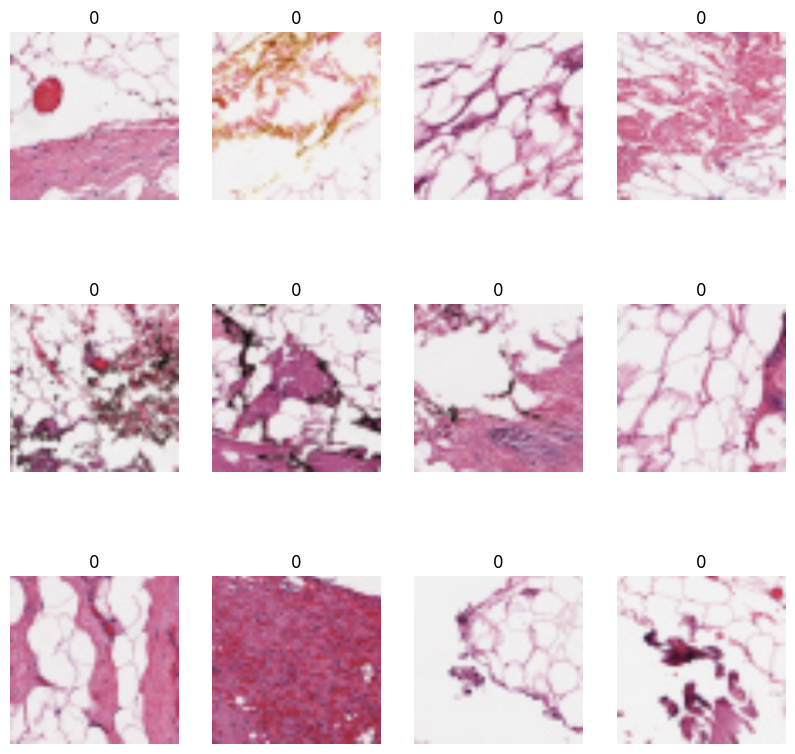

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

18

In [ ]:
train_size = 0.8
len(dataset)*train_size

14.4

In [ ]:
train_ds = dataset.take(14)
len(train_ds)

14

In [ ]:
train_size=0.1
len(dataset)*train_size

1.8

In [ ]:
test_ds = dataset.skip(2)
len(test_ds)

16

In [ ]:
val_size=0.1
len(dataset)*val_size

1.8

In [ ]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [ ]:
test_ds = test_ds.skip(2)
len(test_ds)

14

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Freeze the base model layers
base_model.trainable = False
dropout_rate = 0.2
n_classes = 3

# Create your own model architecture
model = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(dropout_rate),  # Add dropout
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build((None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from keras.callbacks import EarlyStopping

# Create an EarlyStopping callback
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

# Train the model with early stopping
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
    callbacks=[early_stopping]
)



Epoch 1/3
14/14 [==============================] - 11s 466ms/step - loss: 0.6125 - accuracy: 0.7706 - val_loss: 0.5568 - val_accuracy: 0.8125
Epoch 2/3
14/14 [==============================] - 3s 244ms/step - loss: 0.4374 - accuracy: 0.8647 - val_loss: 0.5156 - val_accuracy: 0.8125
Epoch 3/3
14/14 [==============================] - 3s 238ms/step - loss: 0.4230 - accuracy: 0.8647 - val_loss: 0.4858 - val_accuracy: 0.8125


In [ ]:
# To use Support Vector Machines (SVM) with a pre-trained Resnet50 model for binary classification on the same dataset, you can extract features from the pre-trained model and then train an SVM classifier on those features. Here's how you can do it:

# python
# Copy code
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import DenseNet201
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

# Rest of your code for loading and preprocessing data

# Define the model architecture and extract features
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Create a new model that outputs features
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_model = Model(inputs=base_model.input, outputs=x)

# Extract features for training and testing data
X_train_features = feature_model.predict(train_ds.map(lambda x, y: x))
X_test_features = feature_model.predict(test_ds.map(lambda x, y: x))

# Train an SVM classifier
svm_classifier = svm.SVC(kernel='linear')  # You can experiment with different kernels
svm_classifier.fit(X_train_features, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_features)

# Evaluate the SVM classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

3/3 [==============================] - 1s 115ms/step


NameError: ignored

**Resnet + SVM**

In [ ]:
# Define the model architecture and extract features
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False

# Create a new model that outputs features
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_model = Model(inputs=base_model.input, outputs=x)

# Extract features for training and testing data
X_train_features = feature_model.predict(train_dataset.map(lambda x, y: x))
X_test_features = feature_model.predict(test_dataset.map(lambda x, y: x))

# Train an SVM classifier
svm_classifier = svm.SVC(kernel='linear')  # You can experiment with different kernels
svm_classifier.fit(X_train_features, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_features)

# Evaluate the SVM classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)